In [1]:
from patsy import dmatrices
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.metrics import f1_score
import shap
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import random
import seaborn as sns
from matplotlib import pyplot
from sklearn.datasets import make_blobs
import scipy.stats
import pickle

/usr/local/Cellar/jupyterlab/3.4.3/libexec/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import re
import sys
import os
from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav
import numpy as np



In [3]:
####extract features
from os import path
from tqdm import tqdm
import glob
import librosa
import numpy as np
import scipy.io.wavfile as wav

In [4]:
wave_path = "/Users/yuwenyu/Downloads/wavs/"

wav_list = []
wav_name =[]
for subject in range(50):
    for series in range(1,3):
        path = wave_path + str(subject) + "/" + str(series) + "/"
        for wave_fname in os.listdir(path):
            if wave_fname.endswith(".wav"):
                wave = path + wave_fname
                wav_list.append(wave)
                wav_name.append(wave_path+wave_fname)
    
print(len(wav_list))
print(len(wav_name))

2950
2950


In [5]:
def preemphasis(signal, coeff=0.97):
    """Perform preemphasis on the input `signal`."""    
    return np.append(signal[0], signal[1:] - coeff*signal[:-1])


def extract_mfcc_dir(wav_list):
    """
    Extract MFCCs for all audio files in `dir` and return a dictionary.
    Each dictionary key will be the filename of the associated audio file
    without the extension. Deltas and double deltas are also extracted.
    """
    feat_dict = {}
    for i in range(len(wav_list)):
            signal, sample_rate = librosa.core.load(wav_list[i], sr=None)
            signal = preemphasis(signal, coeff=0.97)
            mfcc = librosa.feature.mfcc(
                signal, sr=sample_rate, n_mfcc=13, n_mels=24,  #dct_type=3,
                n_fft=int(np.floor(0.025*sample_rate)),
                hop_length=int(np.floor(0.01*sample_rate)), fmin=64, fmax=8000)
            # mfcc = librosa.feature.mfcc(
            #     signal, sr=sample_rate, n_mfcc=13,
            #     n_fft=int(np.floor(0.025*sample_rate)),
            #     hop_length=int(np.floor(0.01*sample_rate))
            #     )
            mfcc_delta = librosa.feature.delta(mfcc)
            mfcc_delta_delta = librosa.feature.delta(mfcc, order=2)
            # from python_speech_features import delta
            # from python_speech_features import mfcc
            # samplerate, signal = wav.read(wav_fn)
            # mfccs = mfcc(
            #     signal, samplerate=samplerate, winlen=0.025, winstep=0.01,
            #     numcep=13, nfilt=24, nfft=None, lowfreq=0, highfreq=None,
            #     preemph=0.97, ceplifter=22, appendEnergy=True, winfunc=np.hamming
            #     )
            # d_mfccs = delta(mfccs, 2)
            # dd_mfccs = delta(d_mfccs, 2)
            key = wav_name[i] #path.splitext(path.split(wav_fn)[-1])[0]
            feat_dict[key] = np.hstack([mfcc.T, mfcc_delta.T, mfcc_delta_delta.T])
            # import matplotlib.pyplot as plt
            # plt.imshow(feat_dict[key][2000:2200,:])
            # plt.show()
            # assert False
    return feat_dict

In [6]:
df_spanish = pd.read_csv('/Users/yuwenyu/Desktop/CUNY_research/spanish/spanish_normalized.csv')

In [7]:
# create dictionary for label
a = df_spanish[['Filename','Trust_123']].values
res_dct = {}
arr = []
for i in range(len(a)):
    res_dct['/Users/yuwenyu/Downloads/wavs/' + a[i][0]] = a[i][1]

In [8]:
import numpy as np
import torch
from random import randint
from os import path
from tqdm import tqdm
from collections import Counter
import random

def load_data_from_npz():
    npz = extract_mfcc_dir(wav_list) #np.load(data_dir)
    x = []
    labels = []
    speakers = []
    lengths = []
    keys = []
    labels =[]
    n_items = 0
    check_overlap_set = set()

    for utt_key in tqdm(npz):
        print(utt_key)
        cur_x = npz[utt_key]
        label = res_dct[utt_key]
        key = utt_key + '_' + str(label)
        keys.append(key)
        x.append(torch.tensor((cur_x), dtype=torch.float32))
        lengths.append(len(cur_x))
        labels.append(label)
    return (x,lengths, keys, labels) 



In [9]:
from datetime import datetime
from os import path
import argparse
import pickle
import numpy as np
import os
import sys
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence




In [10]:
def collate_fn(batch):
    """
    batch = (data, lengths), data is shape (seq_len, feat_dim)
    """
    seqs = [x[0] for x in batch]
    batch_seqs_padded = pad_sequence(seqs, batch_first=True) # pad variable length sequences to max seq length
    lengths = [x[1] for x in batch]
    batch_lengths = torch.LongTensor(lengths)
    keys = [x[2] for x in batch]
    return batch_seqs_padded, batch_lengths, keys


In [11]:
class npz_data():
    def __init__(self, x_data, lengths, keys, labels):
        self.x_data = x_data
        self.lengths = lengths
        self.keys = keys
        self.labels = labels

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.lengths[idx], self.keys[idx], self.labels[idx]
    
    


In [12]:
def main():
    model_fn = contrastive_rnn()
    npz_fn = load_data_from_npz(data_dir)
    # Embed data
    embed_dict = apply_model(model_fn, npz_fn)
    print("Writing:", npz_fn)
    np.savez_compressed(npz_fn, **embed_dict)
    print(datetime.now())


In [59]:
##### encoder and decoder
options_dict_p = '/Users/yuwenyu/Downloads/options_dict (2).pkl'
with open(options_dict_p, "rb") as f:
    options_dict = pickle.load(f)
    
options_dict
#options_dict['dropout_prob']

{'train_lang': 'xho+nso+ssw+tsn+nbl+eng',
 'val_lang': 'ven',
 'train_tag': 'gt',
 'max_length': 100,
 'bidirectional': False,
 'rnn_type': 'gru',
 'hidden_size': 400,
 'num_layers': 3,
 'bias': True,
 'batch_first': True,
 'ff_n_hiddens': 130,
 'learning_rate': 0.001,
 'dropout': 0.0,
 'n_epochs': 25,
 'batch_size': 600,
 'temperature': 0.1,
 'n_max_pairs': 100000,
 'n_min_tokens_per_type': 2,
 'n_max_types': None,
 'n_max_tokens': None,
 'n_minibatches': 100,
 'rnd_seed': 1,
 'load_model': False,
 'shuffle': True,
 'projection_head': False,
 'save_best': True,
 'pair_list_fn': 'pair_lists/xho+nso+ssw+tsn+nbl+eng/100000.2.None.None.pkl',
 'script': 'train_siamese_rnn',
 'model_dir': 'models/xho+nso+ssw+tsn+nbl+eng.gt/18cdc6b389',
 'device': device(type='cuda'),
 'n_classes': 52258,
 'n_input': 13}

In [15]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence

class encoder_rnn(nn.Module):
    def __init__(self, options_dict, batch_size):
        super(encoder_rnn, self).__init__()
        self.input_size = 39 #options_dict['n_input']
        self.hidden_size = options_dict['hidden_size']
        self.num_layers = options_dict['num_layers']
        self.bias = options_dict['bias']
        self.batch_first = options_dict['batch_first']
        self.dropout = options_dict['dropout']
        self.bidirectional = options_dict['bidirectional']
        self.batch_size = batch_size
        self.device = options_dict['device']
        self.embedding_dim = options_dict['ff_n_hiddens']
        self.rnn_type = options_dict['rnn_type']
        
        if self.bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1

        # Encoding
        if self.rnn_type == 'lstm': 
            self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, bias=self.bias, 
                                batch_first=self.batch_first, dropout=self.dropout, bidirectional=self.bidirectional)
        elif self.rnn_type == 'gru':
            self.gru = nn.GRU(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, bias=self.bias, 
                                batch_first=self.batch_first, dropout=self.dropout, bidirectional=self.bidirectional)
        
        self.fc = nn.Linear(self.hidden_size*self.num_directions, self.embedding_dim)  

           
    def forward(self, x, lengths):            
        # Training mode
        if self.training:
            # Enforce batch first 
            if not self.batch_first:
                x = permute(1,0,2)   # change x from shape (seq_len, batch, input_size) to shape (batch_size, seq_len, input_size)
            
            # Pack padded sequences
            packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
            
            # RNN 
            if self.rnn_type == 'lstm':
                output_lstm, (hidden, _) = self.lstm(packed) # manually set init cell state at init_hidden() - default zero
            elif self.rnn_type == 'gru':
                output_gru, hidden = self.gru(packed)

            # Embedded layer
            out = self.fc(hidden[-1].squeeze())

        # Validation mode
        else:
            packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)

            if self.rnn_type == 'lstm':
                output_lstm, (hidden, _) = self.lstm(packed) # adjust batch size when calling init_hidden() when train and val batch sizes not equal
            elif self.rnn_type == 'gru':
                output_rnn, hidden = self.gru(packed)
                
                # Embedded layer   
            out = self.fc(hidden[-1])

        return out


In [60]:
class decoder_rnn(nn.Module):
    def __init__(self, options_dict, batch_size):
        super(decoder_rnn, self).__init__()
        self.input_size = options_dict['n_input']
        self.hidden_size = options_dict['hidden_size']
        self.num_layers = options_dict['num_layers']
        self.bias = options_dict['bias']
        self.batch_first = options_dict['batch_first']
        self.dropout = 0 #options_dict['dropout_prob']
        self.bidirectional = options_dict['bidirectional']
        self.batch_size = batch_size
        self.device = options_dict['device']
        self.embedding_dim = options_dict['ff_n_hiddens']
        self.rnn_type = options_dict['rnn_type'] 

        if self.bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
        
        # Recurrent layers (decoding)
        if self.rnn_type == 'lstm':   # create sequence of length equal to encoder input sequence length
            self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.hidden_size, num_layers=self.num_layers, bias=self.bias, 
                                batch_first=self.batch_first, dropout=self.dropout, bidirectional=self.bidirectional)
        elif self.rnn_type == 'gru':
            self.gru = nn.GRU(self.embedding_dim, hidden_size=self.hidden_size, num_layers=self.num_layers, bias=self.bias, 
                              batch_first=self.batch_first, dropout=self.dropout, bidirectional=self.bidirectional)
        
        # Final decoded layer
        self.fc = nn.Linear(self.hidden_size*self.num_directions, self.input_size)

    
    def forward(self, x, lengths):

        if self.training:
            packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False) # x contains embedded layer repeated to
            
            if self.rnn_type == 'lstm':                                                                                  # create sequence of length equal to encoder input sequence length
                decoder_rnn_output, (_, _) = self.lstm(packed)
            elif self.rnn_type == 'gru':
                decoder_rnn_output, _ = self.gru(packed)

            unpacked_rnn_output, _ = pad_packed_sequence(decoder_rnn_output, batch_first=True) # (batch, max_seq_length, hidden_size)

            final_output = self.fc(unpacked_rnn_output) # (batch, max_seq_len, 13)

            # Create mask that replace values in rows wirh zeros at indices greater that original seq_len
            mask = [torch.ones(lengths[i],final_output.size(-1)) for i in range(final_output.size(0))]
            mask_padded = torch.nn.utils.rnn.pad_sequence(mask, batch_first=True).to(self.device)

            # Apply mask to final_output
            final_output_masked = torch.mul(final_output, mask_padded)
           
        return final_output_masked



In [48]:

class ae_rnn(nn.Module):
    def __init__(self, options_dict):
        super(ae_rnn, self).__init__()
        self.encoder = encoder_rnn(options_dict, 32) #options_dict['ae_batch_size']
        self.decoder = decoder_rnn(options_dict, 32) #options_dict['ae_batch_size'])

    def forward(self, x, lengths):

        if self.training:
            # Encode padded sequences
            encoded_x = self.encoder(x, lengths) # shape (batch, embed_dim)

            # Apply activation on embeded layer (necessary?)
            encoded_x = torch.nn.functional.relu_(encoded_x)
            
            lengths = [int(length.tolist()) for length in lengths]

            # Decoding
            # need to repeat latent embedding as input to the rnn up to original sequence length (lengths are already sorted in decending)
            sequences = [z.unsqueeze(0).expand(lengths[i],-1) for i, z in enumerate(encoded_x)] # [batch, seq_len_i, hidden_dim]
            sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True) # pad variable length sequences to max seq length

            # Decode padded sequences
            decoded_x = self.decoder(sequences_padded, lengths)

            return decoded_x

        # Only return encoded embeddings
        else:
            return self.encoder(x, lengths)



In [18]:
class cae_rnn(nn.Module):
    def __init__(self, options_dict):
        super(cae_rnn, self).__init__()
        self.encoder = encoder_rnn(options_dict, options_dict['cae_batch_size'])
        self.decoder = decoder_rnn(options_dict, options_dict['cae_batch_size'])

    def forward(self, x, input_lengths, corr_lengths=None):
        
        if self.training:
            # Encode padded sequence, x
            encoded_x = self.encoder(x, input_lengths)
            
            # apply activation on embeded layer (necessary?)
            # encoded_x = torch.nn.functional.relu_(encoded_x)
            
            # Decoding
            # repeat latent embedding as input to the rnn up to corresponding output sequence length (corresponding lengths are not sorted)
            lengths_sorted = [(length,idx)  for (idx,length) in sorted(enumerate(corr_lengths), key=lambda x:x[1], reverse=True)]
            corr_lengths_sorted = [x[0].tolist() for x in lengths_sorted]
            corr_sorting_indices = [x[1] for x in lengths_sorted] # use to rearange corr_lengths to orignal sequence

            encoded_x[range(len(encoded_x))] = encoded_x[corr_sorting_indices]

            corr_sequences = [z.unsqueeze(0).expand(corr_lengths_sorted[i],-1) for i, z in enumerate(encoded_x)] # [batch, seq_len_i, hidden_dim]
            corr_sequences_padded = torch.nn.utils.rnn.pad_sequence(corr_sequences, batch_first=True) # pad variable length sequences to max seq length

            # Decode padded sequences
            decoded_x = self.decoder(corr_sequences_padded, corr_lengths_sorted)

            # Reorder output in orignal order
            final_decoded_x = torch.zeros_like(decoded_x)
            for i in range(len(decoded_x)):                
                final_decoded_x[corr_sorting_indices[i]] = decoded_x[i]

            return final_decoded_x

        else:
            encoded_x = self.encoder(x, input_lengths)
            return encoded_x






In [19]:
class siamese_rnn(nn.Module):
    def __init__(self, options_dict):
        super(siamese_rnn, self).__init__()
        self.encoder = encoder_rnn(options_dict, options_dict["batch_size"])

    def forward(self, x, lengths):
        encoder_rnn_output = self.encoder(x, lengths)
        return encoder_rnn_output

In [20]:
class contrastive_rnn(nn.Module):
    def __init__(self, options_dict):
        super(contrastive_rnn, self).__init__()
        self.encoder = encoder_rnn(options_dict, options_dict["batch_size"])

    def forward(self, x, lengths):
        encoder_rnn_output = self.encoder(x, lengths)
        return encoder_rnn_output


In [21]:
###### MODEL

In [52]:
def apply_model():
    # Load model options
    #model_dir = path.split(model_fn)[0]
    #options_dict_fn = path.join(model_dir, "options_dict.pkl")
    #print("Reading:", options_dict_fn)
    options_dict_fn = '/Users/yuwenyu/Downloads/options_dict (2).pkl'
    with open(options_dict_fn, "rb") as f:
        options_dict = pickle.load(f)

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
    print('Device:', device)  
    options_dict['device'] = device

    # Load data
    x_data, lengths, keys, labels = load_data_from_npz()

    # Truncate and limit dimensionality
    #trunc_and_limit_dim(x_data, lengths, options_dict["n_input"], options_dict["max_length"])

    # Load model
    #model = encoder_rnn(options_dict, options_dict["batch_size"])
    model = ae_rnn(options_dict)
    #model.load_state_dict(torch.load(model_fn,map_location=torch.device('cpu'))["state_dict"], strict=False)
    model.to(device)
    model.eval()

    # Encapuslate data in Dataset and apply Dataloader
    dataset = npz_data(x_data, lengths, keys, labels)
    #print(dataset)  
    dataloader = DataLoader(dataset, batch_size=10000,shuffle=False, drop_last=False, collate_fn=collate_fn)

    # Iterate
    embed_dict = {}
    for batch_seqs_padded, batch_lengths, keys in dataloader:
        #print(batch_seqs_padded.shape)
        batch_seqs_padded  = batch_seqs_padded.to(device)
        np_z = model(batch_seqs_padded, batch_lengths).cpu().detach().numpy()
        #print(np_z)
        # break # Single batch

        for i, utt_key in enumerate(keys):
            a = utt_key
            embed_dict[utt_key] = np_z[i]
            
    return embed_dict



In [23]:
###### plot for embedding

In [24]:
import numpy as np
import os
#from tsnecuda import TSNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter

In [61]:
#output = '/Users/yuwenyu/Downloads/'
#embeddings_fn = os.path.join(output, "eng_val.npz")
#embeddings_npz = np.load(embeddings_fn)
embeddings_npz = apply_model()
keys = [x for x in embeddings_npz]

Device: cpu


Pass y=[-0.04815674 -0.0030011   0.00192657 ... -0.00100098  0.00105743
  0.00241699] as keyword args. From version 0.10 passing these as positional arguments will result in an error
Pass y=[ 0.          0.          0.         ...  0.         -0.00011658
  0.00037354] as keyword args. From version 0.10 passing these as positional arguments will result in an error
Pass y=[ 6.1035156e-05  3.2348631e-05  3.3264158e-05 ... -2.9724138e-04
 -2.5177002e-04  1.9226037e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
Pass y=[ 5.1879883e-04 -3.2012939e-04 -3.9123534e-04 ... -7.0800539e-05
  1.1688238e-04  1.0729982e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
Pass y=[-0.00387573  0.00073822 -0.00198273 ...  0.00047607  0.00076721
  0.00066986] as keyword args. From version 0.10 passing these as positional arguments will result in an error
Pass y=[-5.4626465e-03 -1.1291355e-05  8.4838830e

/Users/yuwenyu/Downloads/wavs/0-1-9-0.wav
/Users/yuwenyu/Downloads/wavs/0-1-8-0.wav
/Users/yuwenyu/Downloads/wavs/0-1-18-0.wav
/Users/yuwenyu/Downloads/wavs/0-1-16-0.wav
/Users/yuwenyu/Downloads/wavs/0-1-2-1.wav
/Users/yuwenyu/Downloads/wavs/0-1-2-0.wav
/Users/yuwenyu/Downloads/wavs/0-1-14-0.wav
/Users/yuwenyu/Downloads/wavs/0-1-10-0.wav
/Users/yuwenyu/Downloads/wavs/0-1-4-0.wav
/Users/yuwenyu/Downloads/wavs/0-1-6-0.wav
/Users/yuwenyu/Downloads/wavs/0-1-12-0.wav
/Users/yuwenyu/Downloads/wavs/0-1-1-0.wav
/Users/yuwenyu/Downloads/wavs/0-1-15-0.wav
/Users/yuwenyu/Downloads/wavs/0-1-1-1.wav
/Users/yuwenyu/Downloads/wavs/0-1-17-0.wav
/Users/yuwenyu/Downloads/wavs/0-1-3-0.wav
/Users/yuwenyu/Downloads/wavs/0-1-7-0.wav
/Users/yuwenyu/Downloads/wavs/0-1-13-0.wav
/Users/yuwenyu/Downloads/wavs/0-1-11-2.wav
/Users/yuwenyu/Downloads/wavs/0-1-11-0.wav
/Users/yuwenyu/Downloads/wavs/0-1-5-0.wav
/Users/yuwenyu/Downloads/wavs/0-1-11-1.wav
/Users/yuwenyu/Downloads/wavs/0-2-8-0.wav
/Users/yuwenyu/Download

100%|████████████████████████████████████| 2950/2950 [00:00<00:00, 10038.80it/s]


/Users/yuwenyu/Downloads/wavs/35-2-1-0.wav
/Users/yuwenyu/Downloads/wavs/35-2-3-0.wav
/Users/yuwenyu/Downloads/wavs/35-2-3-1.wav
/Users/yuwenyu/Downloads/wavs/35-2-18-0.wav
/Users/yuwenyu/Downloads/wavs/35-2-4-0.wav
/Users/yuwenyu/Downloads/wavs/35-2-4-1.wav
/Users/yuwenyu/Downloads/wavs/35-2-6-0.wav
/Users/yuwenyu/Downloads/wavs/35-2-2-0.wav
/Users/yuwenyu/Downloads/wavs/36-1-5-0.wav
/Users/yuwenyu/Downloads/wavs/36-1-11-0.wav
/Users/yuwenyu/Downloads/wavs/36-1-13-0.wav
/Users/yuwenyu/Downloads/wavs/36-1-7-0.wav
/Users/yuwenyu/Downloads/wavs/36-1-3-1.wav
/Users/yuwenyu/Downloads/wavs/36-1-17-0.wav
/Users/yuwenyu/Downloads/wavs/36-1-3-0.wav
/Users/yuwenyu/Downloads/wavs/36-1-3-2.wav
/Users/yuwenyu/Downloads/wavs/36-1-1-0.wav
/Users/yuwenyu/Downloads/wavs/36-1-15-0.wav
/Users/yuwenyu/Downloads/wavs/36-1-1-1.wav
/Users/yuwenyu/Downloads/wavs/36-1-3-3.wav
/Users/yuwenyu/Downloads/wavs/36-1-6-0.wav
/Users/yuwenyu/Downloads/wavs/36-1-12-0.wav
/Users/yuwenyu/Downloads/wavs/36-1-12-1.wav
/Use

In [62]:
# path to embeddings



#embeddings_npz = np.load(embeddings_fn)
keys = [x for x in embeddings_npz]
labels = [x.split("_")[1] for x in embeddings_npz]
#print(keys)
labels_np = np.array(labels)
embeddings = [embeddings_npz[x] for x in embeddings_npz]
embeddings_np = np.array(embeddings)
print(embeddings_np.shape)

(2950, 130)


In [ ]:
#np.random.seed(0)

#most_common_labels = np.array([x[0] for x in Counter(labels).most_common(50)])
#print(most_common_labels)
#rand_idxs = np.random.randint(0, high=50, size=10, dtype=int)
#print(rand_idxs)

In [63]:
#labels_selected = most_common_labels[rand_idxs]
#print(labels_selected)

keys_plot = []
for key in keys:
    #if key.split("_")[1] in labels_selected:
    keys_plot.append(key)
        
embeddings_plot_np = np.array([embeddings_npz[key] for key in keys_plot])
print(embeddings_plot_np.shape)

labels_plot_np = np.array([key.split("_")[1] for key in keys])
print(labels_plot_np)

(2950, 130)
['False' 'False' 'False' ... 'False' 'False' 'False']


In [64]:
X = TSNE(n_components=2, perplexity=30, learning_rate=10).fit_transform(embeddings_plot_np)
print(X.shape)

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.


(2950, 2)


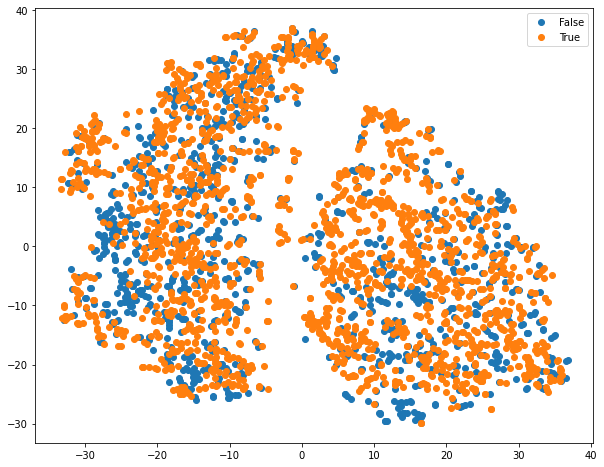

In [65]:

fig = plt.figure(figsize=(10,8))
cmap = plt.get_cmap("tab10")
# print(labels_plot_np)
for label in np.unique(labels_plot_np):
#     print(label)
    plt.scatter(X[labels_plot_np==label][:,0], X[labels_plot_np==label][:,1], cmap=cmap, label=label)
    
    
plt.legend()
plt.show()

In [ ]:
# get classification resutls for Spanish
#find out features of first and second PCA combination

In [ ]:
#get shap plot from training data

In [ ]:
# run the same test 